# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble
import pickle
import pandas as pd

In [ ]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

In [ ]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [10]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
#pred_cols  = ['bestObjID', 'z', 'zErr', 'zphot', 'dzphot']
pred_cols  = ['z', 'zErr'] # This seems to give much more logical results - 'bestObjID' gets all wacky

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the normally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [11]:
# Pre-processing
def clip(tab, col):
    med = np.median(tab[col])
    mad = st.median_abs_deviation(tab[col], scale='normal')
    ran = [med - (5 * mad), med + (5 * mad)]
    tab = tab[tab[col] >= ran[0]]
    tab = tab[tab[col] <= ran[1]]
    return tab


train_tab = Table.read('cat_train.csv')
test_tab = Table.read('cat_test.csv')

train_tab = train_tab[train_tab['zphot_reliable'] == True]
test_tab = test_tab[test_tab['zphot_reliable'] == True]

train_tab = clip(train_tab, train_cols[0])

for col in train_cols:
    train_tab = clip(train_tab, col)
    test_tab = clip(test_tab, col)
    
print(len(train_tab))

/Users/ljnolan/opt/anaconda3/envs/fds/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


350063


<IPython.core.display.Javascript object>


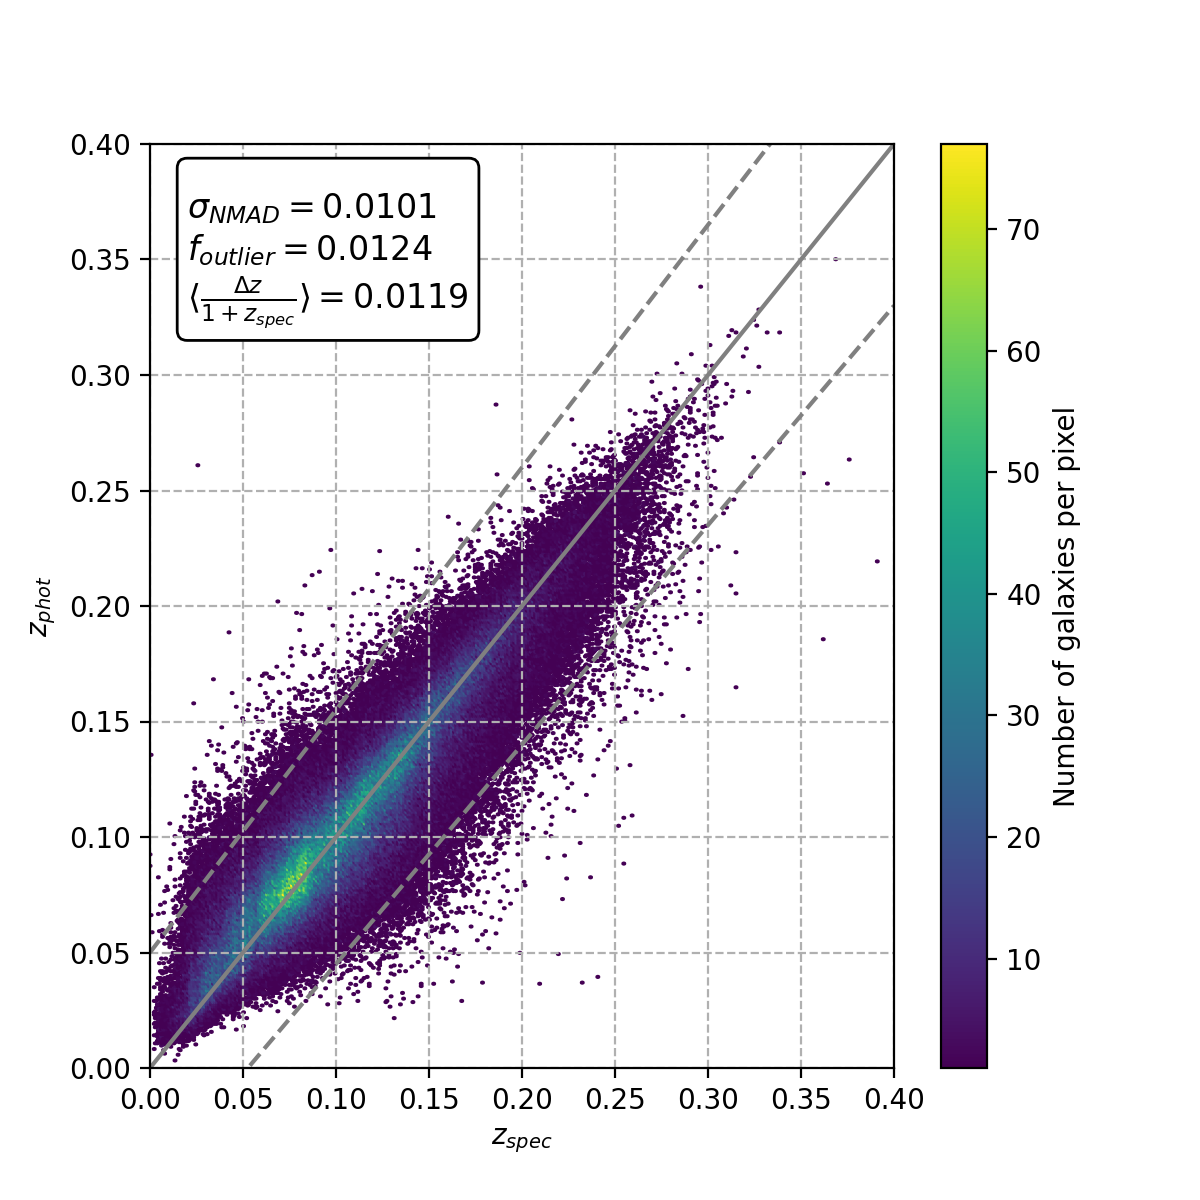

Text(0.05, 0.99, '\n$\\sigma_{NMAD}=0.0101$\n$f_{outlier}=0.0124$\n$\\langle\\frac{\\Delta z}{1+z_{spec}}\\rangle=0.0119$')

In [4]:
# Quantities
sig_nmad = st.median_abs_deviation(train_tab['zphot'] - train_tab['z'])
delz = np.abs((train_tab['z'] - train_tab['zphot']) / (1 + train_tab['z']))
delz_av = np.average(delz)
f_out = float(len(delz[delz > 0.05])) / float(len(delz))

# Plot
fig, ax = plt.subplots(figsize=(6,6))
hb = ax.hexbin(train_tab['z'], train_tab['zphot'], cmap='viridis', mincnt=1, gridsize=(350,350))
cb = fig.colorbar(hb, label='Number of galaxies per pixel')
x0 = np.asarray([0, 0.4])
ax.plot(x0, x0, color='grey', linestyle='-') # z_p = z_s
ax.plot(x0, (1.05 * x0 + 0.05), color='grey', linestyle='--') # delz / (1 + z_s) = 0.05
ax.plot(x0, (0.95 * x0 - 0.05), color='grey', linestyle='--') # - delz / (1 + z_s) = 0.05
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 0.4)
ax.grid(linestyle='--')
ax.set_xlabel(r'$z_{spec}$')
ax.set_ylabel(r'$z_{phot}$')

textstr = '\n'.join(('',
    r'$\sigma_{NMAD}=%.4f$' % (sig_nmad, ),
    r'$f_{outlier}=%.4f$' % (delz_av, ),
    r'$\langle\frac{\Delta z}{1+z_{spec}}\rangle=%.4f$' % (f_out, )))
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(0.05, 0.99, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

In [12]:
n_estimators = [5, 20, 50, 200, 500]
train_pan = train_tab.to_pandas().dropna()
#f = open("rfr_dict.pkl","wb")
#pickle.dump(rfr_dict,f)
#f.close()
oobs = []
fimpts = []
for n in n_estimators:
    rfr = sklearn.ensemble.RandomForestRegressor(n_estimators=n, n_jobs=-1, max_features='sqrt', 
                                                 oob_score=True, random_state=42)
    x = train_pan[train_cols]
    y = train_pan[pred_cols]
    wht = train_pan['zErr'] ** -2
    rfr.fit(x, y, wht)
    oobs.append(rfr.oob_score_)
    fimpts.append(rfr.feature_importances_)

/Users/ljnolan/opt/anaconda3/envs/fds/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ljnolan/opt/anaconda3/envs/fds/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [13]:
rf_tab = Table([n_estimators, oobs], names=('n', 'oobs'))
for c, colname in enumerate(train_cols):
    col = []
    for n in range(len(n_estimators)):
        col.append(fimpts[n][c])
    rf_tab[colname] = col
print(rf_tab)
rf_tab.write('rf.tab', format='ascii', overwrite=True)

 n          oobs         ...      sersicN_r            petroR90_r    
--- -------------------- ... -------------------- -------------------
  5 -0.26315576373513805 ...  0.06503399428909025 0.12385833647492119
 20   0.5073718880281453 ...  0.06298694133599501  0.1120553244010246
 50   0.5542366790353059 ... 0.060686873394430775 0.11166543643444903
200    0.576749808174896 ... 0.060739375751551646  0.1192091644772536
500   0.5811907983718865 ... 0.059466687977676146  0.1105534111779502


<IPython.core.display.Javascript object>


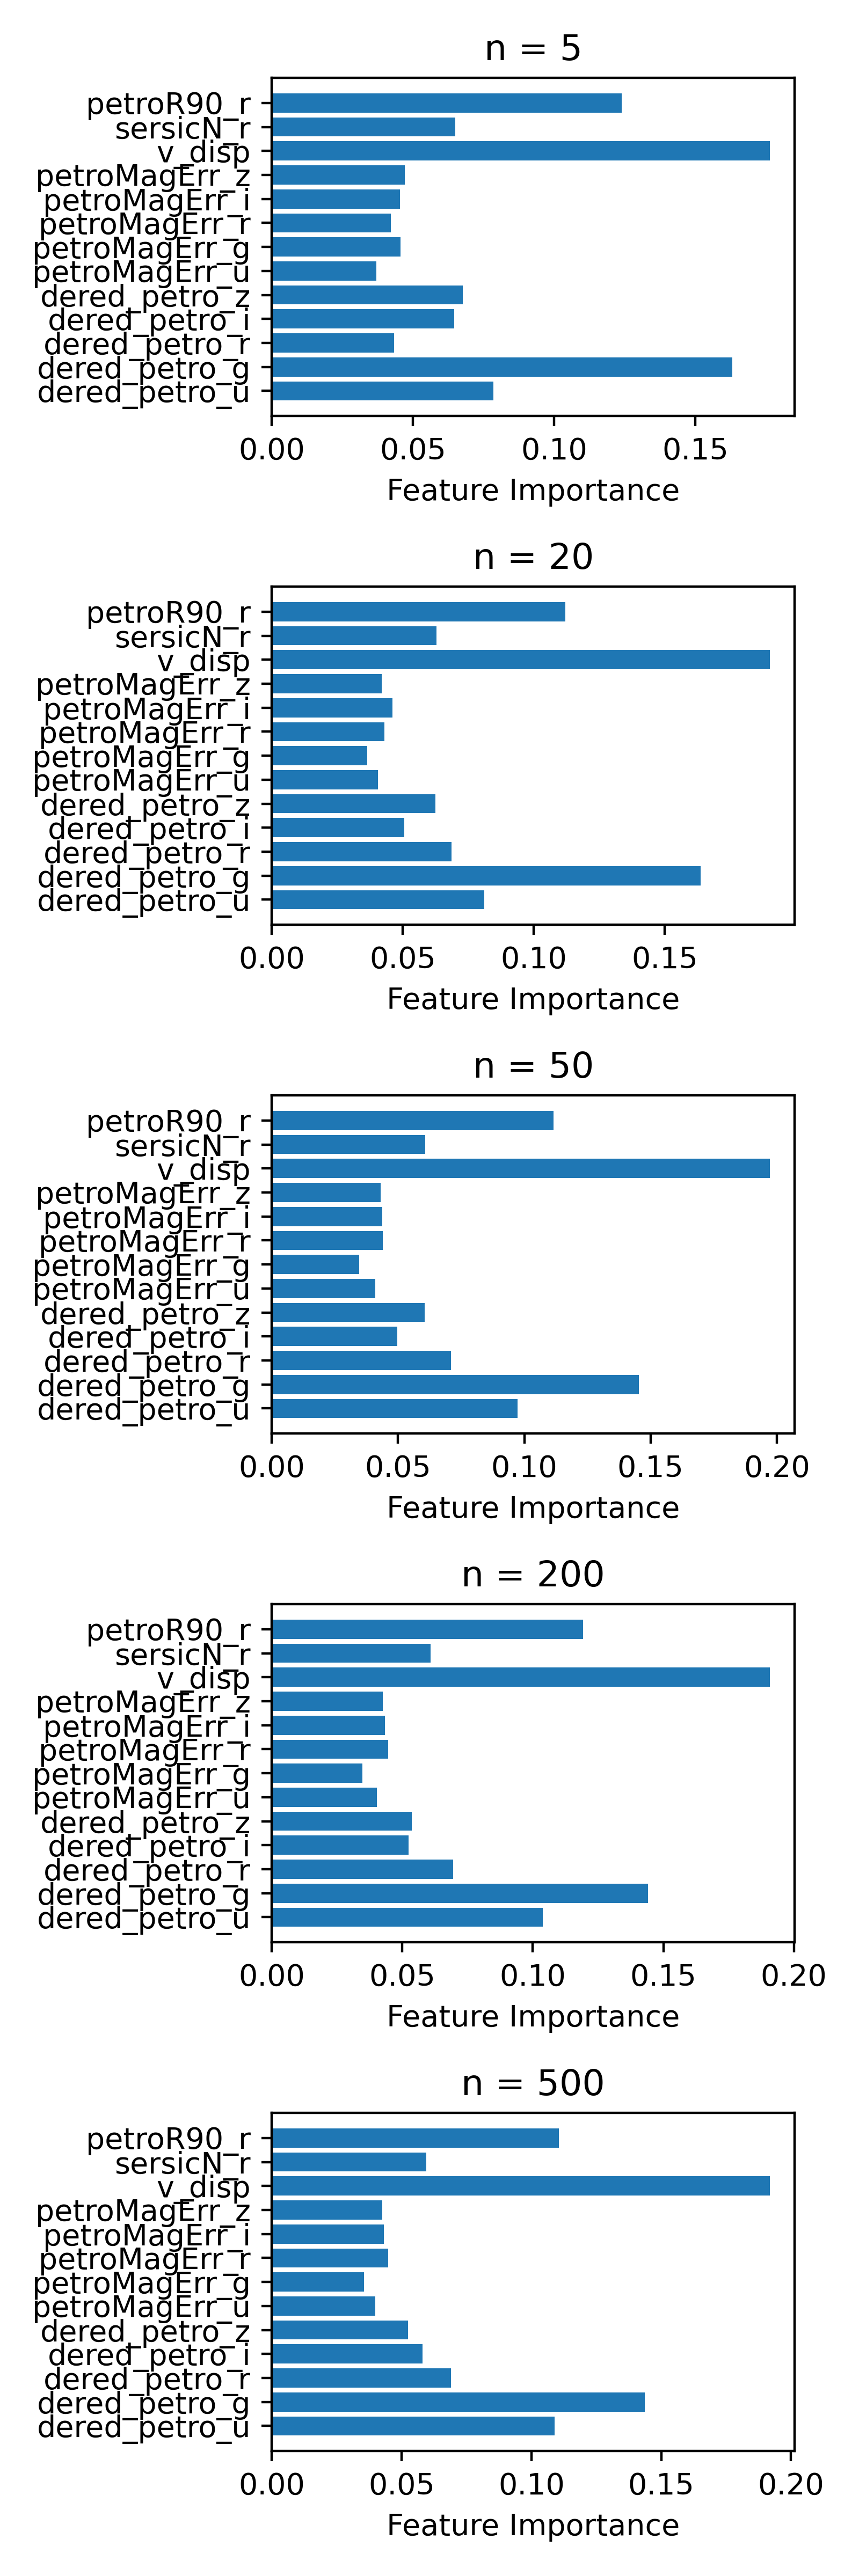

In [14]:
rf_tab = Table.read('rf.tab', format='ascii')

fig, axs = plt.subplots(nrows=len(n_estimators), ncols=1, figsize=(4,12), dpi=200)
for n in range(len(n_estimators)):
    impts = []
    for col in train_cols:
        impts.append(rf_tab[col][n])
    
    ax = axs[n]
    ax.barh(train_cols, impts)
    ax.set_title('n = %i' % n_estimators[n])
    ax.set_xlabel('Feature Importance')

plt.tight_layout()

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

In [15]:
opt_n = n_estimators[np.argmax(rf_tab['oobs'])]
rfr = sklearn.ensemble.RandomForestRegressor(n_estimators=opt_n, n_jobs=-1, max_features='sqrt', 
                                             oob_score=True, random_state=42)
x = train_pan[train_cols]
y = train_pan[pred_cols]
wht = train_pan['zErr'] ** -2
rfr.fit(x, y, wht)
test_pan = test_tab.to_pandas().dropna()
xt = test_pan[train_cols]
pred_pan = pd.DataFrame(rfr.predict(xt), columns=pred_cols)

In [16]:
print(test_pan['z'].values - pred_pan['z'].values)

[-0.00435766  0.00457395  0.01070292 ... -0.01665639  0.00269457
  0.00023237]


<IPython.core.display.Javascript object>


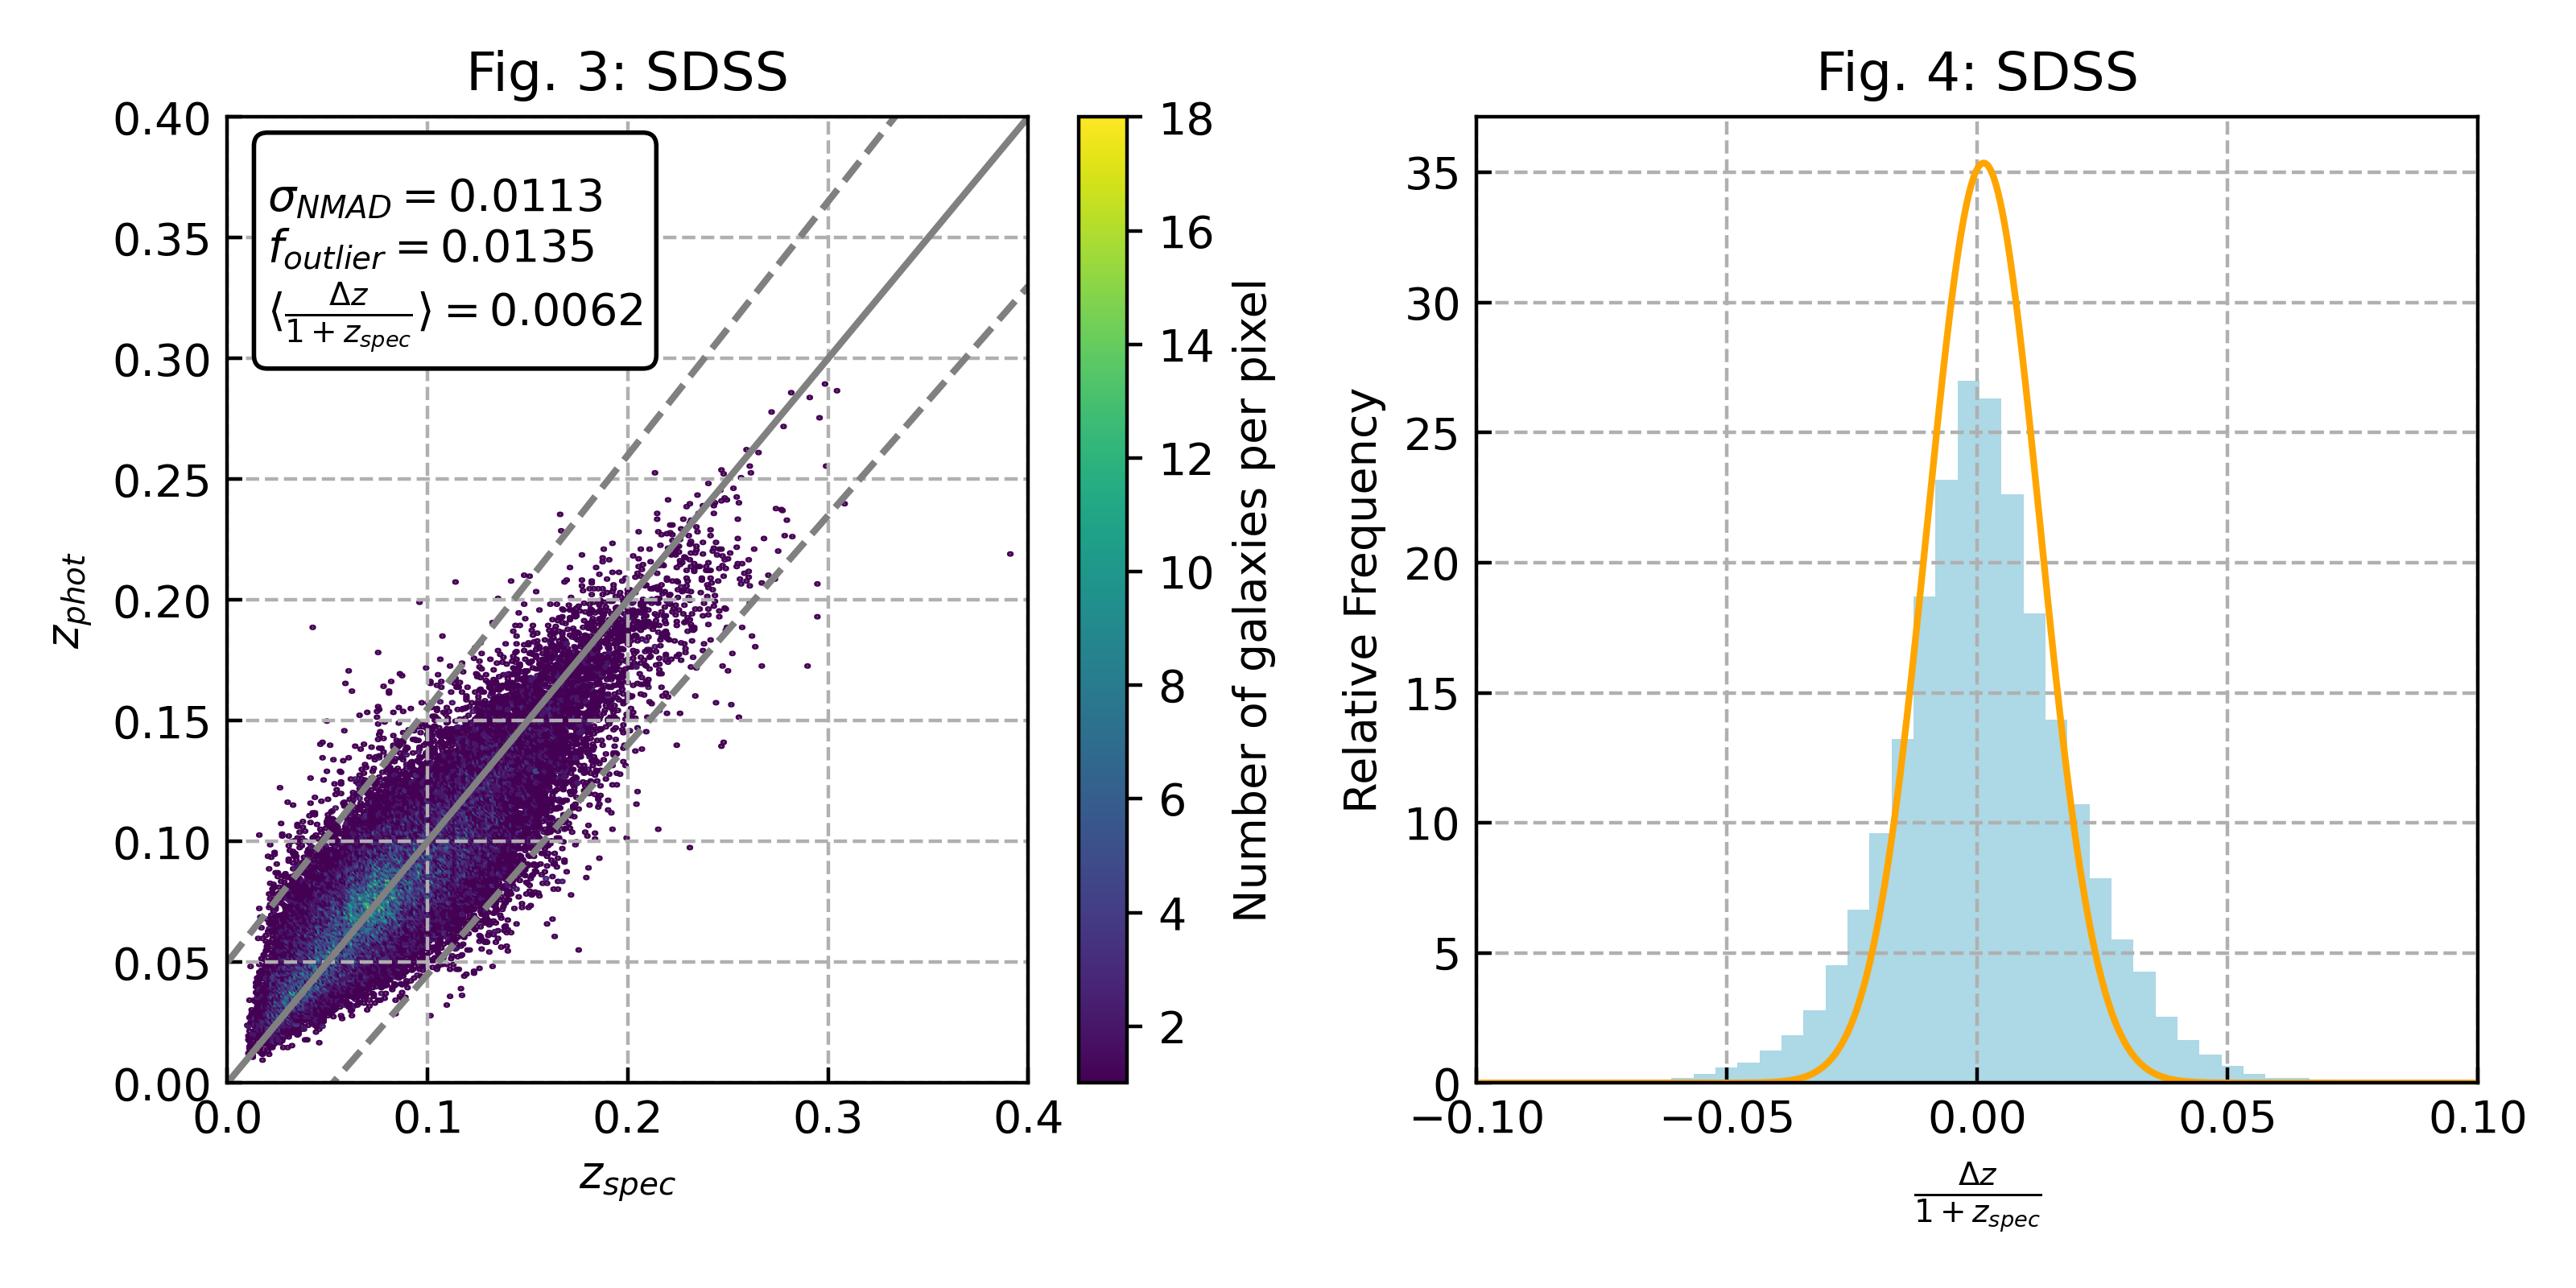

<IPython.core.display.Javascript object>


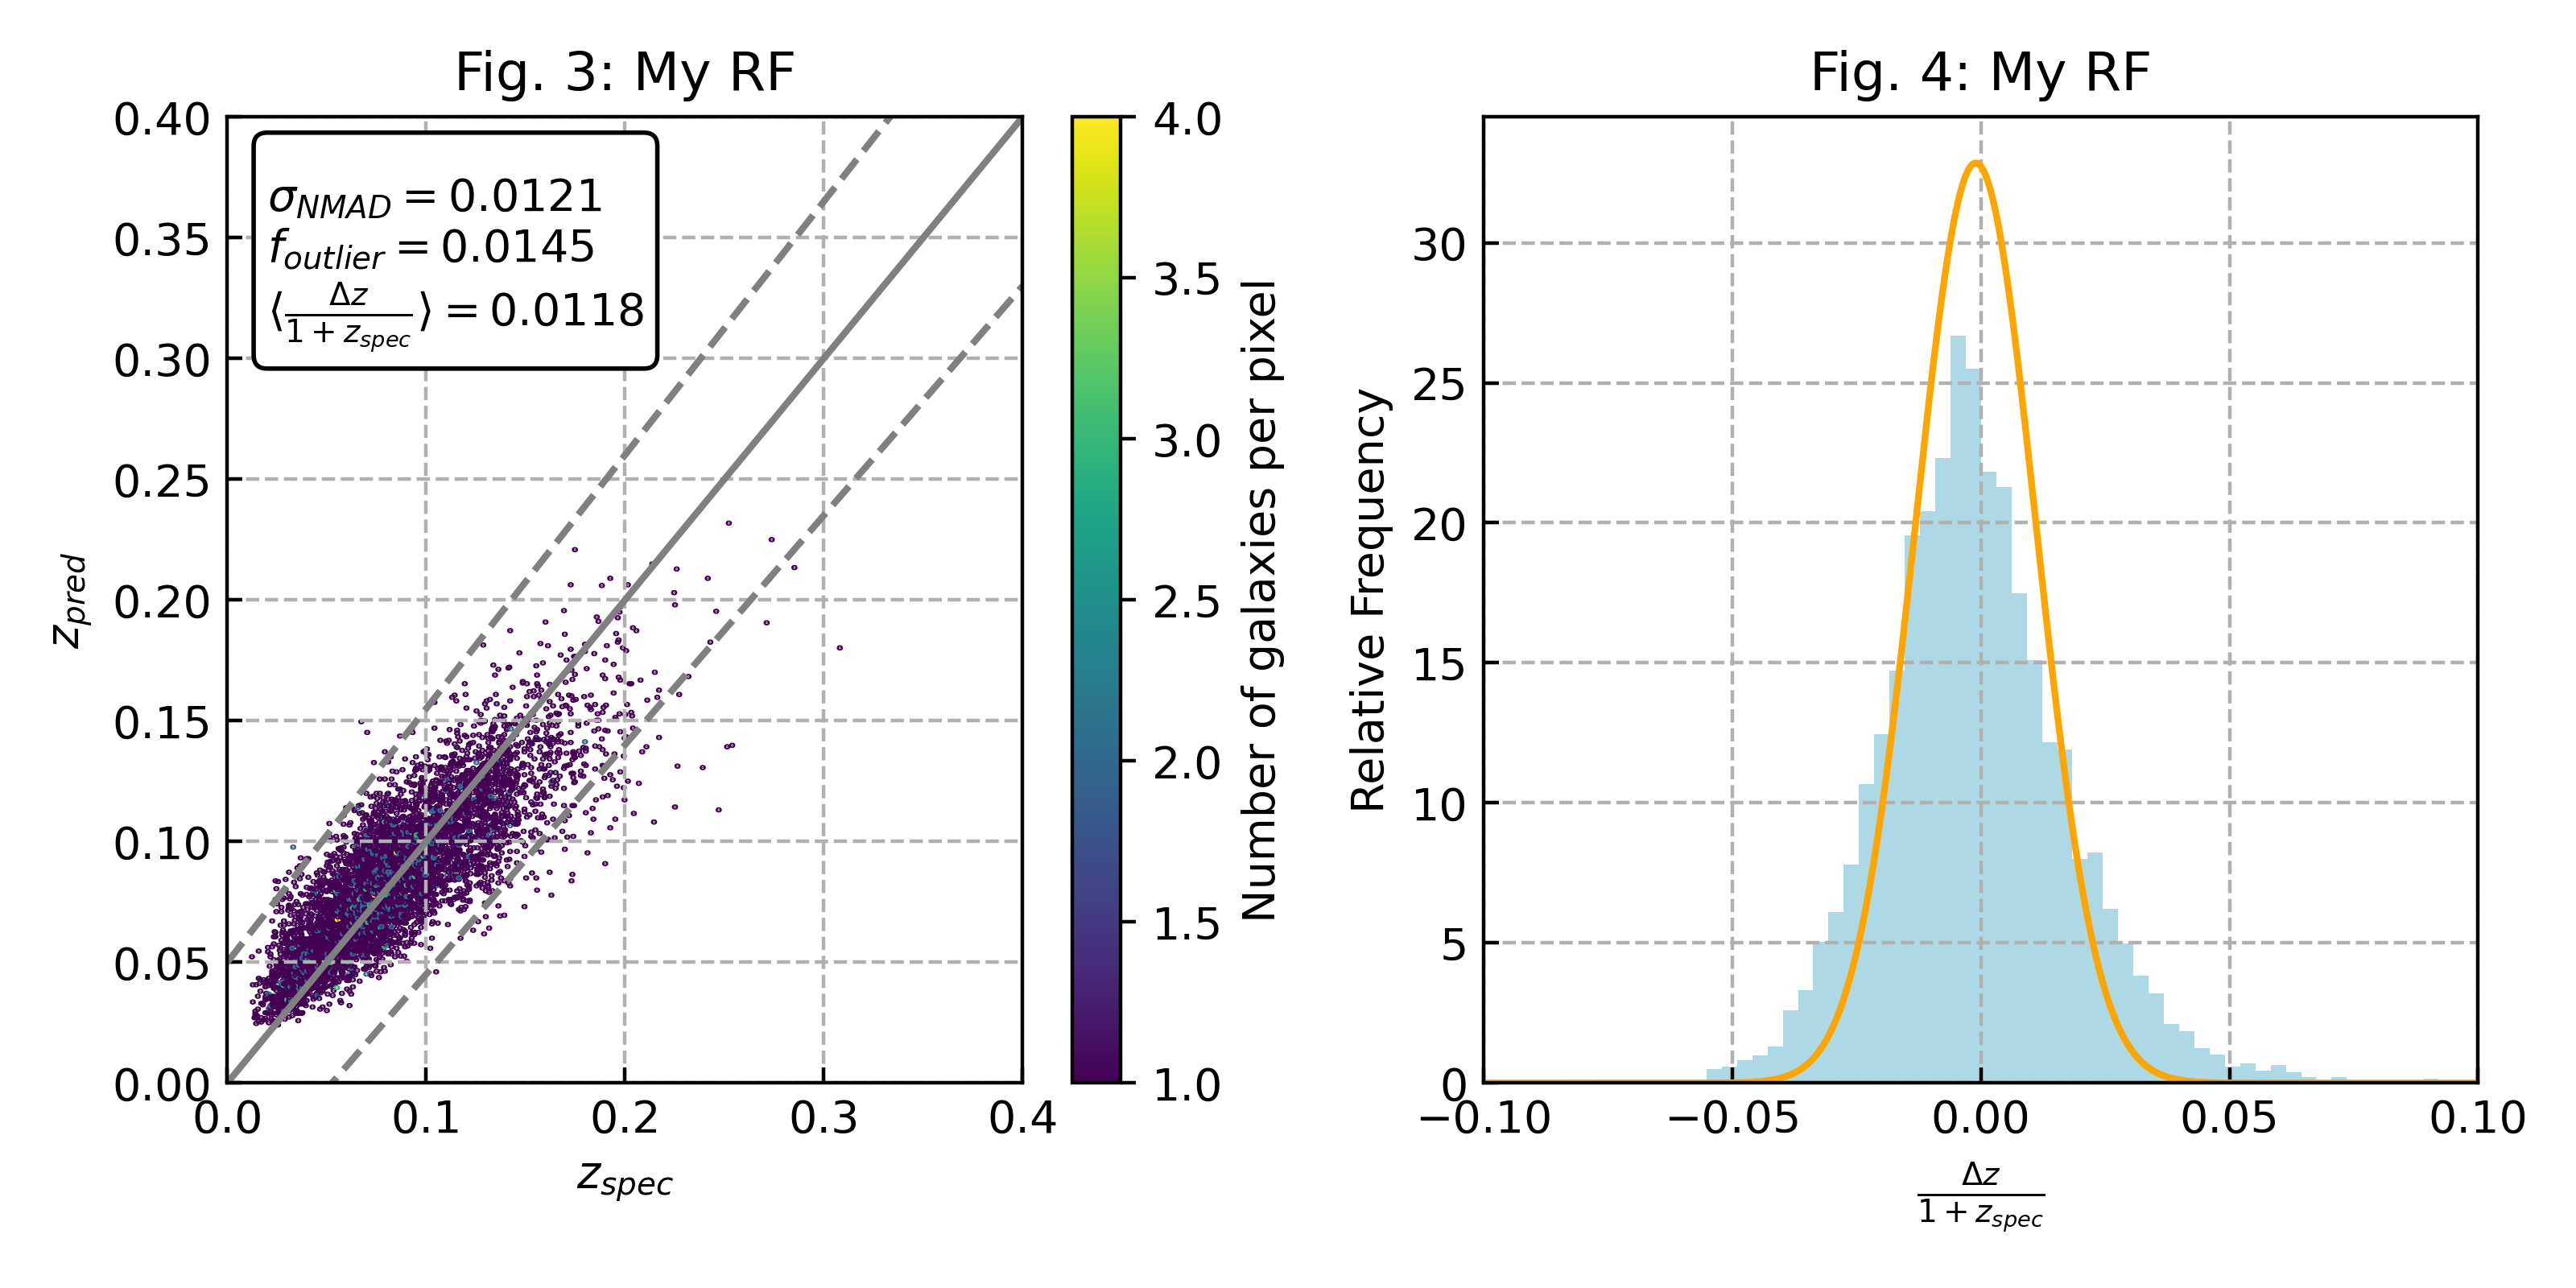

In [17]:
# Plotting time
def makefig34(z, zphot, title):
    # Quantities
    sig_nmad = st.median_abs_deviation(zphot - z)
    delz = (z - zphot) / (1 + z)
    delz_abs = np.abs(delz)
    delz_av = np.average(delz_abs)
    f_out = float(len(delz[delz > 0.05])) / float(len(delz))
    
    # Plot
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), dpi=200)
    
    # Figure 3
    axs[0].tick_params(direction='in')
    hb = axs[0].hexbin(z, zphot, cmap='viridis', mincnt=1, gridsize=(350,350))
    cb = fig.colorbar(hb, label='Number of galaxies per pixel')
    x0 = np.asarray([0, 0.4])
    axs[0].plot(x0, x0, color='grey', linestyle='-') # z_p = z_s
    axs[0].plot(x0, (1.05 * x0 + 0.05), color='grey', linestyle='--') # delz / (1 + z_s) = 0.05
    axs[0].plot(x0, (0.95 * x0 - 0.05), color='grey', linestyle='--') # - delz / (1 + z_s) = 0.05
    axs[0].set_xlim(0, 0.4)
    axs[0].set_ylim(0, 0.4)
    axs[0].grid(linestyle='--')
    axs[0].set_xlabel(r'$z_{spec}$')
    if title == 'SDSS':
        axs[0].set_ylabel(r'$z_{phot}$')
    else:
        axs[0].set_ylabel(r'$z_{pred}$')
    textstr = '\n'.join(('',
                         r'$\sigma_{NMAD}=%.4f$' % (sig_nmad, ),
                         r'$f_{outlier}=%.4f$' % (delz_av, ),
                         r'$\langle\frac{\Delta z}{1+z_{spec}}\rangle=%.4f$' % (f_out, )))
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    axs[0].text(0.05, 0.99, textstr, transform=axs[0].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    axs[0].set_title('Fig. 3: ' + title)
    
    # Figure 4
    bn = 0.1
    xs = np.linspace(-bn, bn, 1000)
    delz_mean = np.average(delz)
    norman = st.norm.pdf(xs, delz_mean, sig_nmad)
    axs[1].plot(xs, norman, color='orange')
    
    axs[1].tick_params(direction='in')
    axs[1].hist(delz, bins=60, density=True, color='lightblue')
    axs[1].set_xlim(-bn, bn)
    axs[1].grid(linestyle='--')
    axs[1].set_xlabel(r'$\frac{\Delta z}{1+z_{spec}}$')
    axs[1].set_ylabel('Relative Frequency')
    axs[1].set_title('Fig. 4: ' + title)
    
    plt.tight_layout()


makefig34(train_pan['z'].values, train_pan['zphot'].values, 'SDSS')
makefig34(test_pan['z'].values, pred_pan['z'].values, 'My RF')